### implement a DCT from first principles

In [1]:
# import statements

from PIL import Image  # this contain the image class and methods from PIL library
import numpy as np # this imports the numerical and array library 
import cv2 
import matplotlib.pyplot as plt # this is for plotting (showing) images 
import math
from scipy import ndimage

In [2]:
# preprocessing image
# Interpolation
# change the picture size
def preprocess_image(pre_im,N):
    height = pre_im.shape[0] 
    width = pre_im.shape[1]
    if height % N != 0:
        height = ((height//N)+1)*N
    if width % N != 0:
        width = ((height//N)+1)*N
    newim = cv2.resize(pre_im,(width,height)) 
    return newim

In [3]:
# 1d_dct function
def dct_wave(N, w):
    wave = np.zeros(N, dtype='float')
    
    if (w==0):
        norm_factor = np.sqrt(1/N)
    else:
        norm_factor = np.sqrt(2/N)
    for i in range(N):   
        wave[i] = norm_factor * np.cos( w * (np.pi * (2*i + 1))/(2*N) )
        
    return wave

In [4]:
# 2d_dtc(kernels)
def dct_wave_2d(N,u,v):

    wave_x = dct_wave(N, u)
    wave_y = dct_wave(N, v)

    return np.outer(wave_x, wave_y)

In [5]:
# create 2D dct basis vectors  
def dct_basis_2d(N):
    basis = np.zeros((N, N, N, N)) 
    for k in range(N):
        for l in range(N):
            basis[k, l] = dct_wave_2d(N,k,l)
    return basis

In [6]:
# calculate the DCT ceofficent
def dct_coefficent(im,N):
    dct_basis = dct_basis_2d(N)
    coefficent= np.zeros(im.shape, dtype='float')
    for i in range(0,im.shape[0],N):
        for j in range(0,im.shape[1],N):
            x = im[i:i+N,j:j+N]  
            coe = np.zeros((N,N),dtype='float')
            for  u in range(0,N):
                for v in range(0,N):
                    b= dct_basis[u,v]
                    coe[u,v]=np.dot(x.flatten(), b.flatten())
            coefficent[i:i+N,j:j+N] = coe
    return coefficent

In [7]:
# reconstruct DCT coefficent
def dct_reconstruct(im,N,n,coeff):
    im_recon = np.zeros(im.shape, dtype='float')
    dct_basis = dct_basis_2d(N)

    for i in range(0,im.shape[0],N):
        for j in range(0,im.shape[1],N):
            coeffs = coeff[i:i+N,j:j+N]   
            recon = np.zeros((N,N),dtype='float')
            for  u in range(0,n):
                for v in range(0,n):
                    recon += coeffs[u,v] * dct_basis[u,v]

            im_recon[i:i+N,j:j+N] = recon
    return (im_recon)

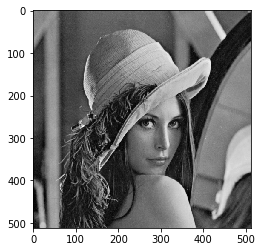

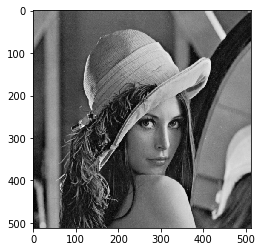

In [8]:
# question 1
# test
# read a image
pre_im = cv2.imread('lena.jpg',0)
N=8
# image after preprocessing
im = preprocess_image(pre_im,N)
plt.imshow(im, cmap='gray')
plt.show()

# the coefficent of im
dctcoeff = dct_coefficent(im,N)

# Reconstruct the image directly with the coefficient
n = N
recon = dct_reconstruct(im,N,n,dctcoeff)
plt.imshow(recon, cmap='gray')
plt.show()

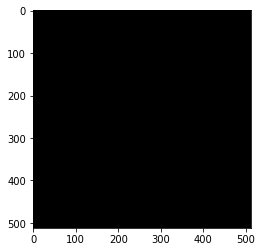

0 12610.455661773682


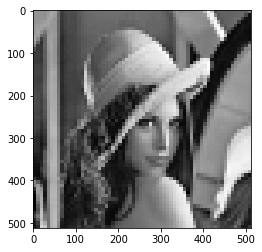

1 357.63696759939194


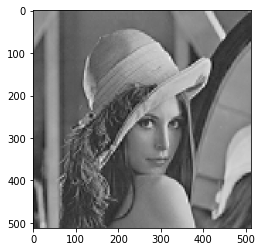

2 133.21626334489164


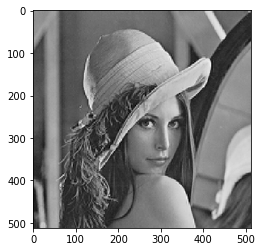

3 63.586195176179956


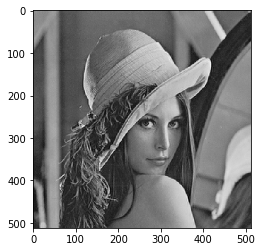

4 33.759396561378566


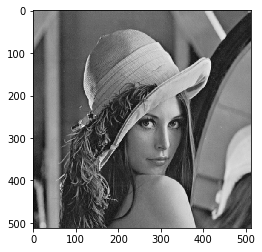

5 18.860947700615814


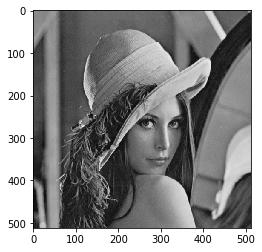

6 10.124361935343442


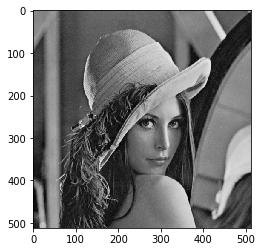

7 4.552318629259849


In [9]:
# MSE of the reconstruction changes with the numbers of coefficents used in the reconstruction

for n in range(N):

        recon = dct_reconstruct(im,N,n,dctcoeff)
        
        plt.imshow(recon, cmap='gray')
        plt.show()
        
        mse = np.mean(np.square(im - recon))
        print(n, mse)

### Use  DCT transform to implement an image compression algorithm.

In [10]:
# calculate compression coefficents by using threshold
def compression_coeff(dct_coeff,threshold_percentage):
    maxnum = dct_coeff.max()
    threshold = maxnum * threshold_percentage
    newcoeff = np.zeros(im.shape, dtype='float')
    for i in range(0,im.shape[0]):
        for j in range(0,im.shape[1]):
            if dct_coeff[i][j] < threshold :
                newcoeff[i][j] = 0
            else:
                newcoeff[i][j] = dct_coeff[i][j]
    return(newcoeff)

In [11]:
# calculate signal noise ratio (dB)
def snrdb(original_image,compression):
    rss = np.mean(np.square(original_image - compression))
    var = np.var(original_image)
    snr = var/rss
    snrdb = 10 * math.log10(snr)
    return(snrdb)

In [12]:
# bits by using Run-length encoding
def total_bits(coefficient):
    coefficient_round = np.round(coefficient)
    coefficient_int = coefficient_round.astype(np.uint8)
    encode = []
    flat_code = coefficient_int.flatten() # flatten the 2d array of coefficent to 1d vector
    # run length encoding
    num = 1
    for i in range(1, len(flat_code)):
        
        if flat_code[i-1] == flat_code[i]:
            num += 1
        else:
            encode.append(flat_code[i-1])
            encode.append(num)
            num = 1
    bits = len(encode) * 8
    return (bits)

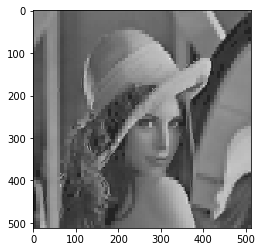

snrdb =  9.948878752972394
the total number of bits is 669360


In [13]:
# Question 2 
#test

# set the threshold
percentage = 0.1
n=N

# calculate the compression coefficent of im and reconstruct the im
compre_coeff = compression_coeff(dctcoeff,percentage)
compression_recon = dct_reconstruct(im,N,n,compre_coeff)
plt.imshow(compression_recon, cmap='gray')
plt.show()

# calculate SNR of reconstruction image
snr = snrdb(im,compression_recon)
print('snrdb = ',snr)

# calculate total_bits of reconstruction image
bits = total_bits(compression_recon)
print('the total number of bits is',bits)

### Quantise DCT coefficients

In [14]:
# calculate quantization coefficients by using given quantisation scheme
def quantise_dct_coeff(im,coeff,N):
    scheme = quan_scheme(N)
    new_quan_coeff = np.zeros(im.shape,dtype='float')
    for i in range(0,im.shape[0],N):
        for j in range(0,im.shape[1],N):
            newcoeff = np.zeros((N,N),dtype='float')
            coeff_block = coeff[i:i+N,j:j+N]
            for k in range(N):
                for l in range(N):
                    newcoeff[k][l] = np.round(coeff_block[k][l]/scheme[k][l])
            new_quan_coeff[i:i+N,j:j+N] = newcoeff
    return(new_quan_coeff)

In [15]:
# given quantisation scheme in question3
def quan_scheme(N):
    scheme = np.zeros((N,N),dtype = 'float')
    for i in range(N):
        for j in range(N):
            if i<2 and j<2 :
                scheme[i][j] = 8
            elif i<4 and j<4:
                scheme[i][j] = 6
            elif i<6 and j<6:
                scheme[i][j] = 4
            elif i<8 and j<8:
                scheme[i][j] = 2
    return (scheme)

In [16]:
# plot DCT rate-distortion curve
def dct_rate_distortion_curve(im,N):
    
    x = []
    y = []
    for i in range(20):
        threshold_percentage  = i * 0.01
        curve_coeff = dct_coefficent(im,N)
        curve_compression= compression_coeff(curve_coeff,threshold_percentage) 
        curve_quantise_dct = quantise_dct_coeff(im,curve_compression,N)
        curve_reconstruct = dct_reconstruct(im,N,n,curve_quantise_dct)
        x.append(total_bits(curve_reconstruct)/np.size(im))
        y.append(snrdb(im,curve_reconstruct))
    plt.plot(x,y)
    plt.xlabel("bit rate") 
    plt.ylabel("SNRdB") 
    plt.show()
    return

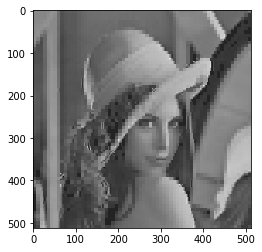

In [17]:
# test  quantazation and recontruct image

compression_re = dct_reconstruct(im,N,n,quantise_dct_coeff(im,compre_coeff,N))
plt.imshow(compression_re, cmap='gray')
plt.show()

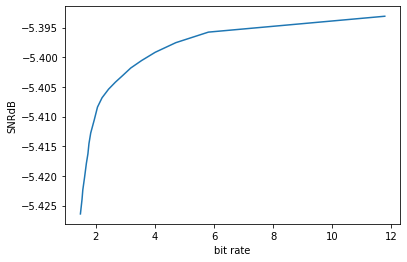

In [18]:
# draw rate distortion curve
dct_rate_distortion_curve(im,N)

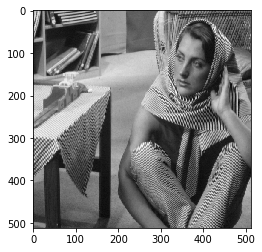

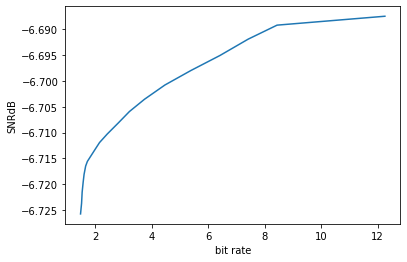

In [19]:
#plot test2 use 'barbara'
pre_im2 = cv2.imread('barbara.bmp',0)

N=8
#preprocessing image
im2 = preprocess_image(pre_im2,N)
plt.imshow(im2, cmap='gray')
plt.show()
n=N
# draw curve
dct_rate_distortion_curve(im2,N)

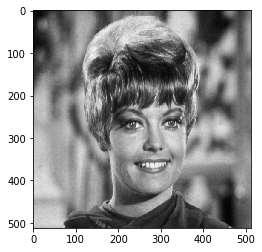

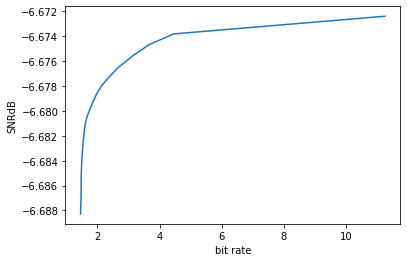

In [20]:
# plot test3 using 'zelda'

pre_im3 = plt.imread('zelda.pgm')

N=8
# preprocessing
im3 = preprocess_image(pre_im3,N)
plt.imshow(im3, cmap='gray')
plt.show()

#draw curve
n=N
dct_rate_distortion_curve(im3,N)

### Gaussian and Laplacian pyramid

In [21]:
#calculate gaussian kernel
def gaussian_kernel(sigma, norm=True):    
    size = int(np.ceil(6 * sigma))  # kernel width is 6 x sigma
    
    if (size%2==0): # make it odd 
        size = size + 1 
        
    kernel = np.zeros((size,size), dtype='float') # kernel array
    
    h = size//2 # half size
    for y in range(0,size):
        for x in range(0,size):
            x2 = (x-h)*(x-h)
            y2 = (y-h)*(y-h)
            kernel[y, x] = np.exp(-(x2+y2)/(2*sigma*sigma))
    
    if norm:
        kernel /= np.sum(kernel) # normalise the kernel
    
    return kernel

In [22]:
# blur the image
def reduce(im, kernel):
    
    # blur the input 
    im_blurred = ndimage.convolve(im.astype('float'), kernel)    
    return im_blurred[::2,::2] # return subsampled version

In [23]:
# upsample the image
def expand(im, kernel):
    # upsample by a factor of two by pixel duplication
    upsampled = np.zeros((2*im.shape[0], 2*im.shape[1]), dtype=im.dtype)

    for i in range(upsampled.shape[0]):
        for j in range(upsampled.shape[1]):
            upsampled[i, j] = im[i//2,j//2]

    # blur the upsampled image
    blurred = ndimage.convolve(upsampled.astype('float'), kernel)

    return blurred

In [24]:
# Show up to 12 pictures in a pyramid
def show_pyramid(pyramid):

    fig = plt.figure(figsize=(18,7))

    for i in range(len(pyramid)):

        plt.subplot(3,4,i+1)
        plt.imshow(pyramid[i], cmap='gray')
        plt.title('level '+str(i))
        plt.xticks([])
        plt.yticks([])

    plt.show()
    return

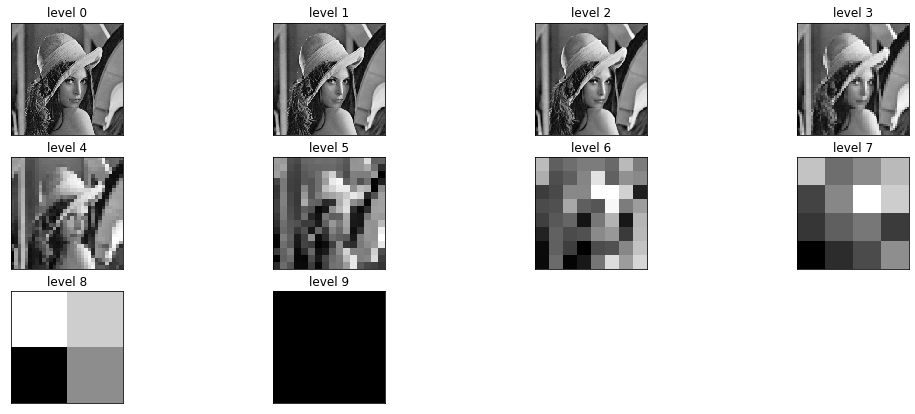

In [25]:
g = gaussian_kernel(0.5)
# gauss pyramid
gauss_pyramid = [] # list to store the generated levels

gauss_pyramid.append(im.astype('float')) # level 0 is the image

n = int(np.log2(im.shape[0]))+1 # assume that the image size is a power of 2
for i in range(1,n):

    level = reduce(gauss_pyramid[i-1], g)

    gauss_pyramid.append(level)
show_pyramid(gauss_pyramid)

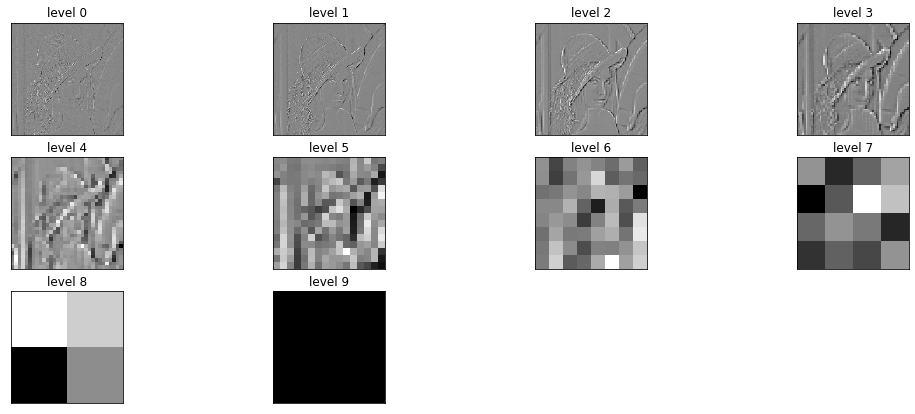

In [26]:
# laplacian pyramid
lap_pyramid = [] # list to store the generated levels

n = int(np.log2(im.shape[0]))+1 # assume that the image size is a power of 2
for i in range(1,n):

    diff = gauss_pyramid[i-1] - expand(gauss_pyramid[i], g)

    lap_pyramid.append(diff)
lap_pyramid.append(gauss_pyramid[9])
show_pyramid(lap_pyramid)

### laplacian compress

In [27]:
# laplacian compress coefficients using threshold
def lap_compress_coeff(pyramid,threshold):
    threshold_coeff = []
    for i in range(len(pyramid)):
        level = pyramid[i]
        newlevel = np.zeros(level.shape,dtype = 'float')
        lap_threshold = level.max() * threshold 
        for k in range(0,level.shape[0]):
            for l in range(0,level.shape[1]):
                if abs(level[k,l]) <  lap_threshold:
                    newlevel[k,l] = 0
                else:
                    newlevel[k,l] = level[k,l]
        threshold_coeff.append(newlevel)
    #show_pyramid(threshold_coeff)
    return (threshold_coeff)

In [28]:
# quantize coeffcients at different levels with different numbers of bits
def lap_quantization(lap_compress_coeff):
    lap_quan = []
    k = len(lap_compress_coeff) 
    
    for i in range(np.size(lap_compress_coeff)):
        level = lap_compress_coeff[i]
        newlevel = np.round(level /(i+1))
        lap_quan.append(newlevel)
    return(lap_quan)
        

In [49]:
# reconstruct image using laplacian coefficient and gauss pyramid
def lap_recon(gauss_pyramid,lapcoeff):
    newgauss = []
    newgauss.append(gauss_pyramid[-1])
    
    for i in range(len(gauss_pyramid)-1):
        level_recon = expand(newgauss[i], g)+lapcoeff[-(i+2)]
        newgauss.append(level_recon)
    recon = newgauss[-1]
    #show_pyramid(newgauss)
    return recon

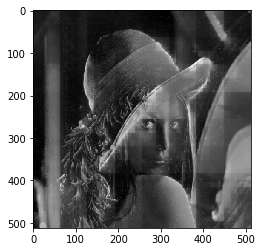

snrdb =  -3.981908196888991
the total number of bits is 3476656


In [50]:
#Question 5
#test

# set the threshold
thresholda = 0.01
# calculate laplacian coefficients
lap_coeff = lap_compress_coeff(lap_pyramid,thresholda)
# reconstruct image using laplacian coefficients
lap_py_recon = lap_recon(gauss_pyramid,lap_coeff)
plt.imshow(lap_py_recon,cmap="gray")
plt.show()
snr = snrdb(im,lap_py_recon)
print('snrdb = ',snr)
bits = total_bits(lap_py_recon)
print('the total number of bits is',bits)

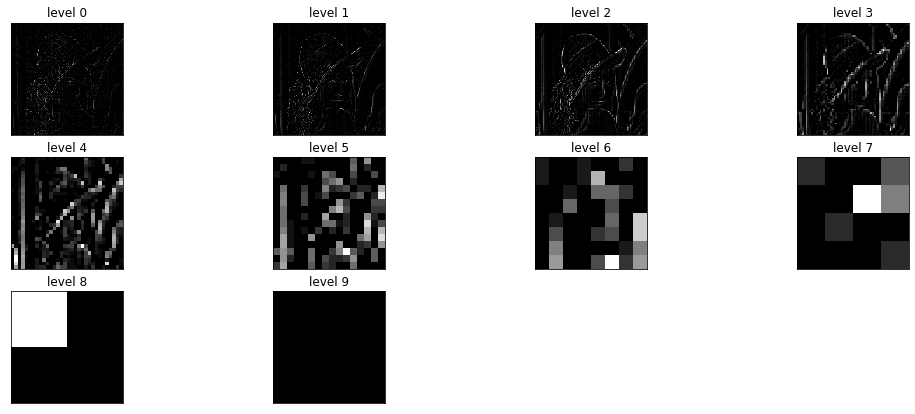

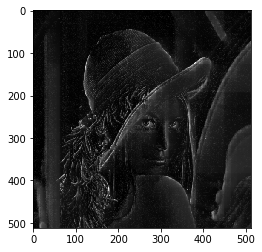

-0.5708065883810425


In [31]:
# test quantization
# calculate coefficients after quantization
lap_coeffquan = lap_quantization(lap_coeff)
show_pyramid(lap_coeffquan)

#reconstruct image using quantization laplacian coefficients
lap_quan_recon=lap_recon(gauss_pyramid,lap_coeffquan)
plt.imshow(lap_quan_recon,cmap="gray")
plt.show()

#calculate the SNR of reonstruction image
lap_quanrecon_snrdb = snrdb(im,lap_quan_recon)
print(lap_quanrecon_snrdb)

In [35]:
#plot laplacian rate distortion curve
def lap_rate_distortion_curve(im,N,lap_pyramid,gauss_pyramid):
    
    x = []
    y = []
    for i in range(30):
        threshold_percentage  = i * 0.01
        curve_coeff = lap_compress_coeff(lap_pyramid,threshold_percentage) 
        curve_quantise = lap_quantization(curve_coeff)
        curve_reconstruct = lap_recon(gauss_pyramid,curve_quantise)
        x.append(total_bits(curve_reconstruct)/np.size(im))
        y.append(snrdb(im,curve_reconstruct))
    plt.plot(x,y)
    plt.xlabel("bit rate") 
    plt.ylabel("SNRdB") 
    plt.show()
    return

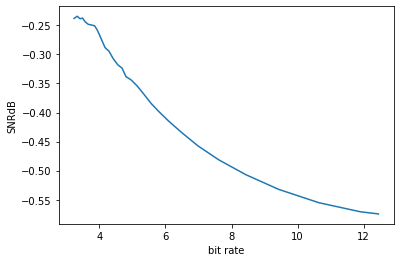

In [36]:
#test plot
lap_rate_distortion_curve(im,N,lap_pyramid,gauss_pyramid)